In [1]:
#Préparation des bibliothèques nécessaires
!pip install eurostat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, accuracy_score
import statsmodels.api as sm
from scipy import stats
import requests
import eurostat

# Dictionnaire pour mapper les codes pays aux noms complets en français
country_mapping = {
    'AT': 'Autriche',
    'BE': 'Belgique',
    'BG': 'Bulgarie',
    'CY': 'Chypre',
    'CZ': 'République tchèque',
    'DE': 'Allemagne',
    'DK': 'Danemark',
    'EE': 'Estonie',
    'ES': 'Espagne',
    'FI': 'Finlande',
    'FR': 'France',
    'GR': 'Grèce',
    'HR': 'Croatie',
    'HU': 'Hongrie',
    'IE': 'Irlande',
    'IT': 'Italie',
    'LT': 'Lituanie',
    'LU': 'Luxembourg',
    'LV': 'Lettonie',
    'MT': 'Malte',
    'NL': 'Pays-Bas',
    'PL': 'Pologne',
    'PT': 'Portugal',
    'RO': 'Roumanie',
    'SE': 'Suède',
    'SI': 'Slovénie',
    'SK': 'Slovaquie',
    'NO': 'Norvège',
    'IS': 'Islande',
    'RS': 'Serbie',
    'TR': 'Türkiye',
    'EU': 'Union européenne - 27 pays (depuis 2020)'
}

# **Santé perçue par soi-même et bien-être (hlth-sph) - Symptômes dépressifs**

## **Symptômes dépressifs actuels par niveau de handicap (restriction d'activité), sexe et âge** : **hlth_ehis_mh1d**


In [7]:
df_hlth_ehis_mh1d = eurostat.get_data_df('hlth_ehis_mh1d')
df_hlth_ehis_mh1d.head()

,freq,hlth_pb,lev_limit,sex,age,unit,geo\TIME_PERIOD,2014,2019
0,A,DPR,MOD,F,TOTAL,PC,AT,7.8,9.3
1,A,DPR,MOD,F,TOTAL,PC,BE,NaN,18.7
2,A,DPR,MOD,F,TOTAL,PC,BG,16.1,12.4
3,A,DPR,MOD,F,TOTAL,PC,CY,8.1,7.9
4,A,DPR,MOD,F,TOTAL,PC,CZ,4.2,7.9


In [8]:
df_hlth_ehis_mh1d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20736 entries, 0 to 20735
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   freq             20736 non-null  object 
 1   hlth_pb          20736 non-null  object 
 2   lev_limit        20736 non-null  object 
 3   sex              20736 non-null  object 
 4   age              20736 non-null  object 
 5   unit             20736 non-null  object 
 6   geo\TIME_PERIOD  20736 non-null  object 
 7   2014             17805 non-null  float64
 8   2019             18606 non-null  float64
dtypes: float64(2), object(7)
memory usage: 1.4+ MB


In [9]:
df_hlth_ehis_mh1d.columns

Index(['freq', 'hlth_pb', 'lev_limit', 'sex', 'age', 'unit', 'geo\TIME_PERIOD',
       '2014', '2019'],
      dtype='object')

In [10]:
# Drop the unwanted columns
df_cleaned_hlth_ehis_mh1d = df_hlth_ehis_mh1d.drop(columns=['freq', 'hlth_pb', 'unit'])

# Filter the data to include only the 2019 column
df_cleaned_hlth_ehis_mh1d = df_cleaned_hlth_ehis_mh1d[['lev_limit', 'sex', 'age', 'geo\\TIME_PERIOD', '2019']]

# Rename pays
df_cleaned_hlth_ehis_mh1d.rename(columns={'geo\\TIME_PERIOD': 'pays'}, inplace=True)

# Display the cleaned data
df_cleaned_hlth_ehis_mh1d.head()

,lev_limit,sex,age,pays,2019
0,MOD,F,TOTAL,AT,9.3
1,MOD,F,TOTAL,BE,18.7
2,MOD,F,TOTAL,BG,12.4
3,MOD,F,TOTAL,CY,7.9
4,MOD,F,TOTAL,CZ,7.9


In [13]:
# Filtrer le DataFrame pour inclure uniquement les lignes avec 'TOTAL' pour sexe et âge
df_total_hlth_ehis_mh1d = df_cleaned_hlth_ehis_mh1d[
    (df_cleaned_hlth_ehis_mh1d['sex'] == 'T') &
    (df_cleaned_hlth_ehis_mh1d['age'] == 'TOTAL')
].copy()  # Utiliser .copy() pour éviter les avertissements liés à la vue

# Remplacer les codes de pays par leurs noms complets en français
df_total_hlth_ehis_mh1d.loc[:, 'pays'] = df_total_hlth_ehis_mh1d['pays'].map(country_mapping)

# Créer la table pivot
pivot_table_hlth_ehis_mh1d = df_total_hlth_ehis_mh1d.pivot_table(
    index='pays',
    columns='lev_limit',
    values='2019'
)

# Remplir les valeurs NaN avec 0 pour une meilleure visualisation
pivot_table_hlth_ehis_mh1d.fillna(0, inplace=True)

# Renommer les niveaux dans le DataFrame pivoté
pivot_table_hlth_ehis_mh1d.rename(columns={
    'NONE': 'aucun',
    'MOD': 'modéré',
    'SM_SEV': 'quelque ou grave',
    'SEV': 'grave',
}, inplace=True)

# Afficher la table pivot
print("Tableau pivot (filtré pour TOTAL sexe et âge):")
print(pivot_table_hlth_ehis_mh1d)

# Spécifier le nom du fichier CSV
csv_filename_hlth_ehis_mh1d = 'data_analysis_hlth_ehis_mh1d_results.csv'

# Générer le fichier CSV sans les niveaux et les labels
pivot_table_hlth_ehis_mh1d.reset_index(inplace=True)  # Réinitialiser l'index pour que 'pays' soit une colonne
pivot_table_hlth_ehis_mh1d.to_csv(csv_filename_hlth_ehis_mh1d, index=False, encoding='utf-8')

# Informer que le CSV a été créé
print(f"Le fichier CSV '{csv_filename_hlth_ehis_mh1d}' a été généré avec succès.")


Tableau pivot (filtré pour TOTAL sexe et âge):
lev_limit              modéré     aucun      grave  quelque ou grave
pays                                                                
Allemagne            9.466667  2.500000  24.000000         12.733333
Autriche             5.166667  1.533333  19.833333          9.200000
Belgique            12.033333  3.333333  24.733333         15.400000
Bulgarie             7.200000  1.000000  22.166667         10.933333
Chypre               4.733333  0.533333  15.266667          8.733333
Croatie              7.466667  1.466667  19.933333         11.300000
Danemark             7.933333  3.466667  30.600000         10.800000
Espagne              7.533333  1.466667  19.833333          9.566667
Estonie              7.400000  2.433333  17.200000         10.133333
Finlande             6.466667  2.733333  16.700000          7.866667
France              11.233333  5.000000  19.466667         14.066667
Hongrie              7.800000  1.266667  18.433333      

## **Symptômes dépressifs actuels par sexe, âge et niveau d'éducation atteint (hlth_ehis_mh1e)**

In [14]:
df_hlth_ehis_mh1e = eurostat.get_data_df('hlth_ehis_mh1e')
df_hlth_ehis_mh1e.head()

,freq,unit,isced11,hlth_pb,sex,age,geo\TIME_PERIOD,2014,2019
0,A,PC,ED0-2,DPR,F,TOTAL,AT,7.5,10.9
1,A,PC,ED0-2,DPR,F,TOTAL,BE,NaN,14.6
2,A,PC,ED0-2,DPR,F,TOTAL,BG,14.2,9.9
3,A,PC,ED0-2,DPR,F,TOTAL,CY,10.2,7.1
4,A,PC,ED0-2,DPR,F,TOTAL,CZ,8.7,6.7


In [15]:
df_hlth_ehis_mh1e.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22455 entries, 0 to 22454
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   freq             22455 non-null  object 
 1   unit             22455 non-null  object 
 2   isced11          22455 non-null  object 
 3   hlth_pb          22455 non-null  object 
 4   sex              22455 non-null  object 
 5   age              22455 non-null  object 
 6   geo\TIME_PERIOD  22455 non-null  object 
 7   2014             20520 non-null  float64
 8   2019             13650 non-null  float64
dtypes: float64(2), object(7)
memory usage: 1.5+ MB


In [16]:
# Drop the unwanted columns
df_cleaned_hlth_ehis_mh1e = df_hlth_ehis_mh1e.drop(columns=['freq', 'hlth_pb', 'unit'])

# Filter the data to include only the 2019 column
df_cleaned_hlth_ehis_mh1e = df_cleaned_hlth_ehis_mh1e[['isced11', 'sex', 'age', 'geo\\TIME_PERIOD', '2019']]

# Rename pays
df_cleaned_hlth_ehis_mh1e.rename(columns={'geo\\TIME_PERIOD': 'pays'}, inplace=True)

# Display the cleaned data
df_cleaned_hlth_ehis_mh1e.head()

,isced11,sex,age,pays,2019
0,ED0-2,F,TOTAL,AT,10.9
1,ED0-2,F,TOTAL,BE,14.6
2,ED0-2,F,TOTAL,BG,9.9
3,ED0-2,F,TOTAL,CY,7.1
4,ED0-2,F,TOTAL,CZ,6.7


In [17]:
# Renommer les colonnes isced11
isced11_mapping = {
    'TOTAL': 'Ensemble des niveaux de la CITE 2011',
    'ED0-2': 'Inférieur à l\'enseignement primaire, enseignement primaire et premier cycle de l\'enseignement secondaire (niveaux 0-2)',
    'ED3_4': 'Deuxième cycle de l\'enseignement secondaire et enseignement post-secondaire non-supérieur (niveaux 3 et 4)',
    'ED5-8': 'Enseignement supérieur (niveaux 5-8)'
}

# Filtrer le DataFrame pour inclure uniquement les lignes avec 'TOTAL' pour sexe et âge
df_total_hlth_ehis_mh1e = df_cleaned_hlth_ehis_mh1e[
    (df_cleaned_hlth_ehis_mh1e['sex'] == 'T') &
    (df_cleaned_hlth_ehis_mh1e['age'] == 'TOTAL')
]

# Remplacer les codes pays par leurs noms complets en français
df_total_hlth_ehis_mh1e.loc[:, 'pays'] = df_total_hlth_ehis_mh1e['pays'].map(country_mapping)

# Créer le tableau pivot avec les nouvelles colonnes renommées
pivot_table_hlth_ehis_mh1e = df_total_hlth_ehis_mh1e.pivot_table(
    index='pays',
    columns='isced11',
    values='2019'
).rename(columns=isced11_mapping)

# Remplir les valeurs NaN avec 0 pour une meilleure lisibilité
pivot_table_hlth_ehis_mh1e.fillna(0, inplace=True)

# Afficher le tableau pivot
print("Tableau pivot (filtré pour TOTAL sexe et âge) :")
print(pivot_table_hlth_ehis_mh1e)

# Nom du fichier CSV à générer
csv_filename_hlth_ehis_mh1e = 'data_analysis_hlth_ehis_mh1e_results.csv'

# Générer le fichier CSV sans niveaux et labels
pivot_table_hlth_ehis_mh1e.reset_index(inplace=True)  # Réinitialiser l'index pour rendre 'pays' une colonne
pivot_table_hlth_ehis_mh1e.to_csv(csv_filename_hlth_ehis_mh1e, index=False, encoding='utf-8')

# Informer que le fichier CSV a été créé
print(f"Le fichier CSV '{csv_filename_hlth_ehis_mh1e}' a été généré avec succès.")


Tableau pivot (filtré pour TOTAL sexe et âge) :
isced11             Inférieur à l'enseignement primaire, enseignement primaire et premier cycle de l'enseignement secondaire (niveaux 0-2)  \
pays                                                                                                                                         
Allemagne                                                    8.866667                                                                        
Autriche                                                     6.500000                                                                        
Belgique                                                     8.233333                                                                        
Bulgarie                                                     5.066667                                                                        
Chypre                                                       3.533333                               

## Symptômes dépressifs actuels par sexe, âge et quintile de revenu (hlth_ehis_mh1i)**bold text**

In [18]:
df_hlth_ehis_mh1i= eurostat.get_data_df('hlth_ehis_mh1i')
df_hlth_ehis_mh1i.head()

,freq,unit,hlth_pb,quant_inc,sex,age,geo\TIME_PERIOD,2014,2019
0,A,PC,DPR,QU1,F,TOTAL,AT,8.2,11.5
1,A,PC,DPR,QU1,F,TOTAL,BE,NaN,14.7
2,A,PC,DPR,QU1,F,TOTAL,BG,14.3,11.2
3,A,PC,DPR,QU1,F,TOTAL,CY,7.5,5.9
4,A,PC,DPR,QU1,F,TOTAL,CZ,7.0,8.0


In [19]:
df_hlth_ehis_mh1i.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33642 entries, 0 to 33641
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   freq             33642 non-null  object 
 1   unit             33642 non-null  object 
 2   hlth_pb          33642 non-null  object 
 3   quant_inc        33642 non-null  object 
 4   sex              33642 non-null  object 
 5   age              33642 non-null  object 
 6   geo\TIME_PERIOD  33642 non-null  object 
 7   2014             30642 non-null  float64
 8   2019             20304 non-null  float64
dtypes: float64(2), object(7)
memory usage: 2.3+ MB


In [20]:
df_hlth_ehis_mh1i.columns

Index(['freq', 'unit', 'hlth_pb', 'quant_inc', 'sex', 'age', 'geo\TIME_PERIOD',
       '2014', '2019'],
      dtype='object')

In [21]:
# Drop the unwanted columns
df_cleaned_hlth_ehis_mh1i = df_hlth_ehis_mh1i.drop(columns=['freq', 'hlth_pb', 'unit'])

# Filter the data to include only the 2019 column
df_cleaned_hlth_ehis_mh1i = df_cleaned_hlth_ehis_mh1i[['quant_inc', 'sex', 'age', 'geo\\TIME_PERIOD', '2019']]

# Rename pays
df_cleaned_hlth_ehis_mh1i.rename(columns={'geo\\TIME_PERIOD': 'pays'}, inplace=True)

# Display the cleaned data
df_cleaned_hlth_ehis_mh1i.head()

,quant_inc,sex,age,pays,2019
0,QU1,F,TOTAL,AT,11.5
1,QU1,F,TOTAL,BE,14.7
2,QU1,F,TOTAL,BG,11.2
3,QU1,F,TOTAL,CY,5.9
4,QU1,F,TOTAL,CZ,8.0


In [22]:
# Renommer les colonnes quant_inc
quant_inc_mapping = {
    'QU1': 'Premier quintile',
    'QU2': 'Second quintile',
    'QU3': 'Troisième quintile',
    'QU4': 'Quartième quintile',
    'QU5': 'Cinquième quintile'
}

# Filtrer le DataFrame pour inclure uniquement les lignes avec 'TOTAL' pour sexe et âge
df_total_hlth_ehis_mh1i = df_cleaned_hlth_ehis_mh1i[
    (df_cleaned_hlth_ehis_mh1i['sex'] == 'T') &
    (df_cleaned_hlth_ehis_mh1i['age'] == 'TOTAL')
]

# Remplacer les codes pays par leurs noms complets en français
df_total_hlth_ehis_mh1i.loc[:, 'pays'] = df_total_hlth_ehis_mh1i['pays'].map(country_mapping)

# Créer le tableau pivot avec les nouvelles colonnes renommées
pivot_table_hlth_ehis_mh1i = df_total_hlth_ehis_mh1i.pivot_table(
    index='pays',
    columns='quant_inc',
    values='2019'
).rename(columns=quant_inc_mapping)

# Remplir les valeurs NaN avec 0 pour une meilleure lisibilité
pivot_table_hlth_ehis_mh1i.fillna(0, inplace=True)

# Afficher le tableau pivot
print("Tableau pivot (filtré pour TOTAL sexe et âge) :")
print(pivot_table_hlth_ehis_mh1i)

# Nom du fichier CSV à générer
csv_filename_hlth_ehis_mh1i = 'data_analysis_hlth_ehis_mh1i_results.csv'

# Générer le fichier CSV sans niveaux et labels
pivot_table_hlth_ehis_mh1i.reset_index(inplace=True)  # Réinitialiser l'index pour rendre 'pays' une colonne
pivot_table_hlth_ehis_mh1i.to_csv(csv_filename_hlth_ehis_mh1i, index=False, encoding='utf-8')

# Informer que le fichier CSV a été créé
print(f"Le fichier CSV '{csv_filename_hlth_ehis_mh1i}' a été généré avec succès.")


Tableau pivot (filtré pour TOTAL sexe et âge) :
quant_inc           Premier quintile  Second quintile  Troisième quintile  \
pays                                                                        
Allemagne                  10.800000         7.066667            5.933333   
Autriche                    6.800000         4.600000            2.966667   
Belgique                   10.800000         6.733333            7.666667   
Bulgarie                    6.533333         4.633333            2.733333   
Chypre                      3.533333         2.000000            1.200000   
Croatie                     9.000000        10.866667            6.933333   
Danemark                    9.733333         5.366667            4.433333   
Espagne                     4.166667         3.800000            3.266667   
Estonie                     9.866667         7.733333            5.066667   
Finlande                    6.800000         5.666667            3.566667   
France                     1

## **Symptômes dépressifs actuels par sexe, âge et degré d'urbanisation (hlth_ehis_mh1u)**

In [23]:
df_hlth_ehis_mh1u= eurostat.get_data_df('hlth_ehis_mh1u')
df_hlth_ehis_mh1u.head()

,freq,hlth_pb,deg_urb,sex,age,unit,geo\TIME_PERIOD,2014,2019
0,A,DPR,DEG1,F,TOTAL,PC,AT,6.1,7.7
1,A,DPR,DEG1,F,TOTAL,PC,BE,NaN,11.2
2,A,DPR,DEG1,F,TOTAL,PC,BG,8.2,5.1
3,A,DPR,DEG1,F,TOTAL,PC,CY,5.8,3.6
4,A,DPR,DEG1,F,TOTAL,PC,CZ,3.6,6.3


In [24]:
df_hlth_ehis_mh1u.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22356 entries, 0 to 22355
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   freq             22356 non-null  object 
 1   hlth_pb          22356 non-null  object 
 2   deg_urb          22356 non-null  object 
 3   sex              22356 non-null  object 
 4   age              22356 non-null  object 
 5   unit             22356 non-null  object 
 6   geo\TIME_PERIOD  22356 non-null  object 
 7   2014             19920 non-null  float64
 8   2019             13758 non-null  float64
dtypes: float64(2), object(7)
memory usage: 1.5+ MB


In [25]:
df_hlth_ehis_mh1u.columns

Index(['freq', 'hlth_pb', 'deg_urb', 'sex', 'age', 'unit', 'geo\TIME_PERIOD',
       '2014', '2019'],
      dtype='object')

In [26]:
# Drop the unwanted columns
df_cleaned_hlth_ehis_mh1u = df_hlth_ehis_mh1u.drop(columns=['freq', 'hlth_pb', 'unit'])

# Filter the data to include only the 2019 column
df_cleaned_hlth_ehis_mh1u = df_cleaned_hlth_ehis_mh1u[['deg_urb', 'sex', 'age', 'geo\\TIME_PERIOD', '2019']]

# Rename pays
df_cleaned_hlth_ehis_mh1u.rename(columns={'geo\\TIME_PERIOD': 'pays'}, inplace=True)

# Display the cleaned data
df_cleaned_hlth_ehis_mh1u.head()

,deg_urb,sex,age,pays,2019
0,DEG1,F,TOTAL,AT,7.7
1,DEG1,F,TOTAL,BE,11.2
2,DEG1,F,TOTAL,BG,5.1
3,DEG1,F,TOTAL,CY,3.6
4,DEG1,F,TOTAL,CZ,6.3


In [27]:
# Renommer les colonnes DEG1, DEG2, DEG3
deg_urb_mapping = {
    'DEG1': 'Villes',
    'DEG2': 'Villes moins peuplées et banlieues',
    'DEG3': 'Zones rurales'
}

# Filtrer le DataFrame pour inclure uniquement les lignes avec 'TOTAL' pour sexe et âge
df_total_hlth_ehis_mh1u = df_cleaned_hlth_ehis_mh1u[
    (df_cleaned_hlth_ehis_mh1u['sex'] == 'T') &
    (df_cleaned_hlth_ehis_mh1u['age'] == 'TOTAL')
]

# Remplacer les codes pays par leurs noms complets en français
df_total_hlth_ehis_mh1u.loc[:, 'pays'] = df_total_hlth_ehis_mh1u['pays'].map(country_mapping)

# Créer le tableau pivot avec les nouvelles colonnes renommées
pivot_table_hlth_ehis_mh1u = df_total_hlth_ehis_mh1u.pivot_table(
    index='pays',
    columns='deg_urb',
    values='2019'
).rename(columns=deg_urb_mapping)

# Remplir les valeurs NaN avec 0 pour une meilleure lisibilité
pivot_table_hlth_ehis_mh1u.fillna(0, inplace=True)

# Afficher le tableau pivot
print("Tableau pivot (filtré pour TOTAL sexe et âge) :")
print(pivot_table_hlth_ehis_mh1u)

# Nom du fichier CSV à générer
csv_filename_hlth_ehis_mh1u = 'data_analysis_hlth_ehis_mh1u_results.csv'

# Générer le fichier CSV sans niveaux et labels
pivot_table_hlth_ehis_mh1u.reset_index(inplace=True)  # Réinitialiser l'index pour rendre 'pays' une colonne
pivot_table_hlth_ehis_mh1u.to_csv(csv_filename_hlth_ehis_mh1u, index=False, encoding='utf-8')

# Informer que le fichier CSV a été créé
print(f"Le fichier CSV '{csv_filename_hlth_ehis_mh1u}' a été généré avec succès.")


Tableau pivot (filtré pour TOTAL sexe et âge) :
deg_urb               Villes  Villes moins peuplées et banlieues  \
pays                                                               
Allemagne           6.833333                            6.066667   
Autriche            4.533333                            3.500000   
Belgique            6.933333                            5.200000   
Bulgarie            2.800000                            2.733333   
Chypre              1.866667                            1.200000   
Croatie             6.066667                            5.866667   
Danemark            5.266667                            5.733333   
Espagne             3.133333                            3.400000   
Estonie             5.766667                            4.866667   
Finlande            4.833333                            4.066667   
France              7.900000                            7.233333   
Hongrie             3.600000                            3.133333   


## **List all the datasets tehn group them all in one dataset**

In [29]:
pivot_table_hlth_ehis_mh1d.head()


lev_limit,pays,modéré,aucun,grave,quelque ou grave
0,Allemagne,9.466667,2.500000,24.000000,12.733333
1,Autriche,5.166667,1.533333,19.833333,9.200000
2,Belgique,12.033333,3.333333,24.733333,15.400000
3,Bulgarie,7.200000,1.000000,22.166667,10.933333
4,Chypre,4.733333,0.533333,15.266667,8.733333


In [30]:
pivot_table_hlth_ehis_mh1e.head()


isced11,pays,"Inférieur à l'enseignement primaire, enseignement primaire et premier cycle de l'enseignement secondaire (niveaux 0-2)",Deuxième cycle de l'enseignement secondaire et enseignement post-secondaire non-supérieur (niveaux 3 et 4),Enseignement supérieur (niveaux 5-8),Ensemble des niveaux de la CITE 2011
0,Allemagne,8.866667,6.300000,3.333333,6.066667
1,Autriche,6.500000,3.466667,2.466667,3.733333
2,Belgique,8.233333,6.000000,4.333333,5.966667
3,Bulgarie,5.066667,2.600000,1.933333,3.000000
4,Chypre,3.533333,1.266667,0.800000,1.666667


In [33]:
pivot_table_hlth_ehis_mh1i.head()

quant_inc,pays,Premier quintile,Second quintile,Troisième quintile,Quartième quintile,Cinquième quintile,TOTAL
0,Allemagne,10.800000,7.066667,5.933333,3.800000,3.066667,6.066667
1,Autriche,6.800000,4.600000,2.966667,2.200000,1.800000,3.733333
2,Belgique,10.800000,6.733333,7.666667,5.000000,3.500000,5.966667
3,Bulgarie,6.533333,4.633333,2.733333,2.466667,1.300000,3.000000
4,Chypre,3.533333,2.000000,1.200000,1.133333,0.700000,1.666667


In [34]:
pivot_table_hlth_ehis_mh1u.head()

deg_urb,pays,Villes,Villes moins peuplées et banlieues,Zones rurales,TOTAL
0,Allemagne,6.833333,6.066667,4.833333,6.066667
1,Autriche,4.533333,3.500000,3.366667,3.733333
2,Belgique,6.933333,5.200000,6.266667,5.966667
3,Bulgarie,2.800000,2.733333,3.866667,3.000000
4,Chypre,1.866667,1.200000,1.466667,1.666667


In [40]:
import pandas as pd

# Réinitialiser les index des tables pivot pour inclure 'pays' comme colonne normale
pivot_table_hlth_ehis_mh1d.reset_index(inplace=True, drop=True)
pivot_table_hlth_ehis_mh1e.reset_index(inplace=True, drop=True)
pivot_table_hlth_ehis_mh1i.reset_index(inplace=True, drop=True)
pivot_table_hlth_ehis_mh1u.reset_index(inplace=True, drop=True)

# Fusionner les tables successivement sur la colonne 'pays'
datable = pivot_table_hlth_ehis_mh1d.merge(
    pivot_table_hlth_ehis_mh1e, on='pays', how='inner', suffixes=('_mh1d', '_mh1e')
).merge(
    pivot_table_hlth_ehis_mh1i, on='pays', how='inner', suffixes=('', '_mh1i')
).merge(
    pivot_table_hlth_ehis_mh1u, on='pays', how='inner', suffixes=('', '_mh1u')
)

# Supprimer les colonnes inutiles comme 'level_0', 'index' et celles contenant 'TOTAL'
datable.drop(columns=[col for col in datable.columns if col.startswith('level') or col.startswith('index') or 'TOTAL' in col.upper()], inplace=True)

# Arrondir toutes les valeurs numériques à 2 décimales
for col in datable.select_dtypes(include=['float', 'int']).columns:
    datable[col] = datable[col].round(2)

# Afficher les premières lignes du DataFrame final
print("DataFrame final combiné (datable) avec colonnes inutiles supprimées et valeurs arrondies à 2 décimales :")
print(datable.head())

# Exporter le DataFrame combiné dans un fichier CSV sans index
csv_filename_datable = 'combined_datatable_cleaned.csv'
datable.to_csv(csv_filename_datable, index=False, encoding='utf-8')

# Informer que le fichier CSV a été créé
print(f"Le fichier CSV '{csv_filename_datable}' a été généré avec succès sans colonnes inutiles ni index, et avec des valeurs arrondies à 2 décimales.")


DataFrame final combiné (datable) avec colonnes inutiles supprimées et valeurs arrondies à 2 décimales :
        pays  modéré  aucun  grave  quelque ou grave  \
0  Allemagne    9.47   2.50  24.00             12.73   
1   Autriche    5.17   1.53  19.83              9.20   
2   Belgique   12.03   3.33  24.73             15.40   
3   Bulgarie    7.20   1.00  22.17             10.93   
4     Chypre    4.73   0.53  15.27              8.73   

   Inférieur à l'enseignement primaire, enseignement primaire et premier cycle de l'enseignement secondaire (niveaux 0-2)  \
0                                               8.87                                                                        
1                                               6.50                                                                        
2                                               8.23                                                                        
3                                               5.07      

In [41]:
datable.head()

,pays,modéré,aucun,grave,quelque ou grave,"Inférieur à l'enseignement primaire, enseignement primaire et premier cycle de l'enseignement secondaire (niveaux 0-2)",Deuxième cycle de l'enseignement secondaire et enseignement post-secondaire non-supérieur (niveaux 3 et 4),Enseignement supérieur (niveaux 5-8),Ensemble des niveaux de la CITE 2011,Premier quintile,Second quintile,Troisième quintile,Quartième quintile,Cinquième quintile,Villes,Villes moins peuplées et banlieues,Zones rurales
0,Allemagne,9.47,2.50,24.00,12.73,8.87,6.30,3.33,6.07,10.80,7.07,5.93,3.80,3.07,6.83,6.07,4.83
1,Autriche,5.17,1.53,19.83,9.20,6.50,3.47,2.47,3.73,6.80,4.60,2.97,2.20,1.80,4.53,3.50,3.37
2,Belgique,12.03,3.33,24.73,15.40,8.23,6.00,4.33,5.97,10.80,6.73,7.67,5.00,3.50,6.93,5.20,6.27
3,Bulgarie,7.20,1.00,22.17,10.93,5.07,2.60,1.93,3.00,6.53,4.63,2.73,2.47,1.30,2.80,2.73,3.87
4,Chypre,4.73,0.53,15.27,8.73,3.53,1.27,0.80,1.67,3.53,2.00,1.20,1.13,0.70,1.87,1.20,1.47


In [42]:
datable.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 17 columns):
 #   Column                                                                                                                  Non-Null Count  Dtype  
---  ------                                                                                                                  --------------  -----  
 0   pays                                                                                                                    29 non-null     object 
 1   modéré                                                                                                                  29 non-null     float64
 2   aucun                                                                                                                   29 non-null     float64
 3   grave                                                                                                                   29 non-null     float64
 4 

In [43]:
datable.columns

Index(['pays', 'modéré', 'aucun', 'grave', 'quelque ou grave',
       'Inférieur à l'enseignement primaire, enseignement primaire et premier cycle de l'enseignement secondaire (niveaux 0-2)',
       'Deuxième cycle de l'enseignement secondaire et enseignement post-secondaire non-supérieur (niveaux 3 et 4)',
       'Enseignement supérieur (niveaux 5-8)',
       'Ensemble des niveaux de la CITE 2011', 'Premier quintile',
       'Second quintile', 'Troisième quintile', 'Quartième quintile',
       'Cinquième quintile', 'Villes', 'Villes moins peuplées et banlieues',
       'Zones rurales'],
      dtype='object')

# **Limitations d'ordre fonctionnel ou dans les activités usuelles (hlth_fal)**

## **Difficultés graves aux activités de soins personnels ou aux activités domestiques par sexe, âge et type d'activité où la difficulté grave est rencontrée (hlth_ehis_tadle)**

In [ ]:
df_hlth_ehis_tadle = eurostat.get_data_df('hlth_ehis_tadle')
df_hlth_ehis_tadle.head()

,freq,unit,yes_no,sex,age,geo\TIME_PERIOD,2014,2019
0,A,PC,NO_SDIF,F,Y55-64,AT,NaN,91.2
1,A,PC,NO_SDIF,F,Y55-64,BE,NaN,89.0
2,A,PC,NO_SDIF,F,Y55-64,BG,NaN,89.6
3,A,PC,NO_SDIF,F,Y55-64,CY,NaN,88.7
4,A,PC,NO_SDIF,F,Y55-64,CZ,NaN,88.1


In [ ]:
df_hlth_ehis_tadle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1992 entries, 0 to 1991
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   freq             1992 non-null   object 
 1   unit             1992 non-null   object 
 2   yes_no           1992 non-null   object 
 3   sex              1992 non-null   object 
 4   age              1992 non-null   object 
 5   geo\TIME_PERIOD  1992 non-null   object 
 6   2014             1188 non-null   float64
 7   2019             1908 non-null   float64
dtypes: float64(2), object(6)
memory usage: 124.6+ KB


In [ ]:
df_hlth_ehis_tadle.columns

Index(['freq', 'unit', 'yes_no', 'sex', 'age', 'geo\TIME_PERIOD', '2014',
       '2019'],
      dtype='object')

In [ ]:
# Drop the unwanted columns
df_cleaned = df_hlth_ehis_tadle.drop(columns=['freq', 'unit'])

# Filter the data to include only the 2019 column
df_cleaned = df_cleaned[['yes_no', 'sex', 'age', 'geo\\TIME_PERIOD', '2019']]

# Rename pays
df_cleaned.rename(columns={'geo\\TIME_PERIOD': 'pays'}, inplace=True)

# Display the cleaned data
df_cleaned.head()

,yes_no,sex,age,pays,2019
0,NO_SDIF,F,Y55-64,AT,91.2
1,NO_SDIF,F,Y55-64,BE,89.0
2,NO_SDIF,F,Y55-64,BG,89.6
3,NO_SDIF,F,Y55-64,CY,88.7
4,NO_SDIF,F,Y55-64,CZ,88.1


In [ ]:
# Filtrer données pour total (sex == 'T')
df_total = df_hlth_ehis_tadle[df_hlth_ehis_tadle['sex'] == 'T']

# Renommer colonne avant de mapper
df_total = df_total.rename(columns={'geo\\TIME_PERIOD': 'pays'})

# Mapper les pays
df_total['pays'] = df_total['pays'].map(country_mapping)

# Créer tableau pivoté
df_pivoted = pd.pivot_table(df_total,
                            values='2019',
                            index=['pays', 'age'],
                            columns='yes_no',
                            aggfunc='mean')

# Réinitialiser index
df_pivoted = df_pivoted.reset_index()


# Afficher données pivotées
print(df_pivoted.head())

yes_no       pays     age  NO_SDIF  YES_SDIF_ADL  YES_SDIF_IADL  YES_SDIF_TADL
0       Allemagne  Y55-64     92.3           0.6            5.2            1.9
1       Allemagne  Y65-74     91.3           0.7            5.0            3.0
2       Allemagne  Y_GE55     86.6           0.9            8.5            4.0
3       Allemagne  Y_GE65     82.7           1.1           10.7            5.5
4       Allemagne  Y_GE75     74.9           1.5           15.8            7.7


In [ ]:
df_pivoted = df_pivoted.rename(columns={
    'YES_SDIF_TADL': 'Difficulté grave à la fois pour effectuer des soins personnels ainsi que d\'accomplir des activités domestiques - toutes les activités de la vie quotidienne (TAVQ)',
    'YES_SDIF_ADL': 'Difficulté grave uniquement pour effectuer des soins personnels - activités de la vie quotidienne (AVQ)',
    'YES_SDIF_IADL': 'Difficulté grave uniquement pour accomplir des activités domestiques - activités instrumentales de la vie quotidienne (AIVQ)',
    'NO_SDIF': 'Aucune difficulté grave'
})

# Display pivoted data after renaming columns
print(df_pivoted.head())

yes_no       pays     age  Aucune difficulté grave  \
0       Allemagne  Y55-64                     92.3   
1       Allemagne  Y65-74                     91.3   
2       Allemagne  Y_GE55                     86.6   
3       Allemagne  Y_GE65                     82.7   
4       Allemagne  Y_GE75                     74.9   

yes_no  Difficulté grave uniquement pour effectuer des soins personnels - activités de la vie quotidienne (AVQ)  \
0                                                     0.6                                                         
1                                                     0.7                                                         
2                                                     0.9                                                         
3                                                     1.1                                                         
4                                                     1.5                                           

In [ ]:
# Nom du fichier CSV à générer
csv_filename = 'data_analysis_hlth_ehis_tadle_results.csv'

# Générer le fichier CSV sans niveaux et labels
df_pivoted.to_csv(csv_filename, index=False)

# Informer que le fichier CSV a été créé
print(f"Le fichier CSV '{csv_filename}' a été généré avec succès.")


Le fichier CSV 'data_analysis_hlth_ehis_tadle_results.csv' a été généré avec succès.



Résultats ANOVA pour Aucune difficulté grave:
F-statistic: 89.9182
p-value: 0.0000

Résultats du test de Tukey:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
Y55-64 Y65-74  -5.8494 0.0552 -11.8016   0.1027  False
Y55-64 Y_GE75 -31.3494    0.0 -37.3016 -25.3973   True
Y65-74 Y_GE75    -25.5    0.0 -31.4015 -19.5985   True
------------------------------------------------------

Résultats ANOVA pour Difficulté grave uniquement pour effectuer des soins personnels - activités de la vie quotidienne (AVQ):
F-statistic: 11.4960
p-value: 0.0000

Résultats du test de Tukey:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
Y55-64 Y65-74   0.1009 0.5868 -0.1428 0.3447  False
Y55-64 Y_GE75   0.4643 0.0001  0.2205  0.708   True
Y65-74 Y_GE75   0.3633 0.0016  0.1217  0.605   Tr

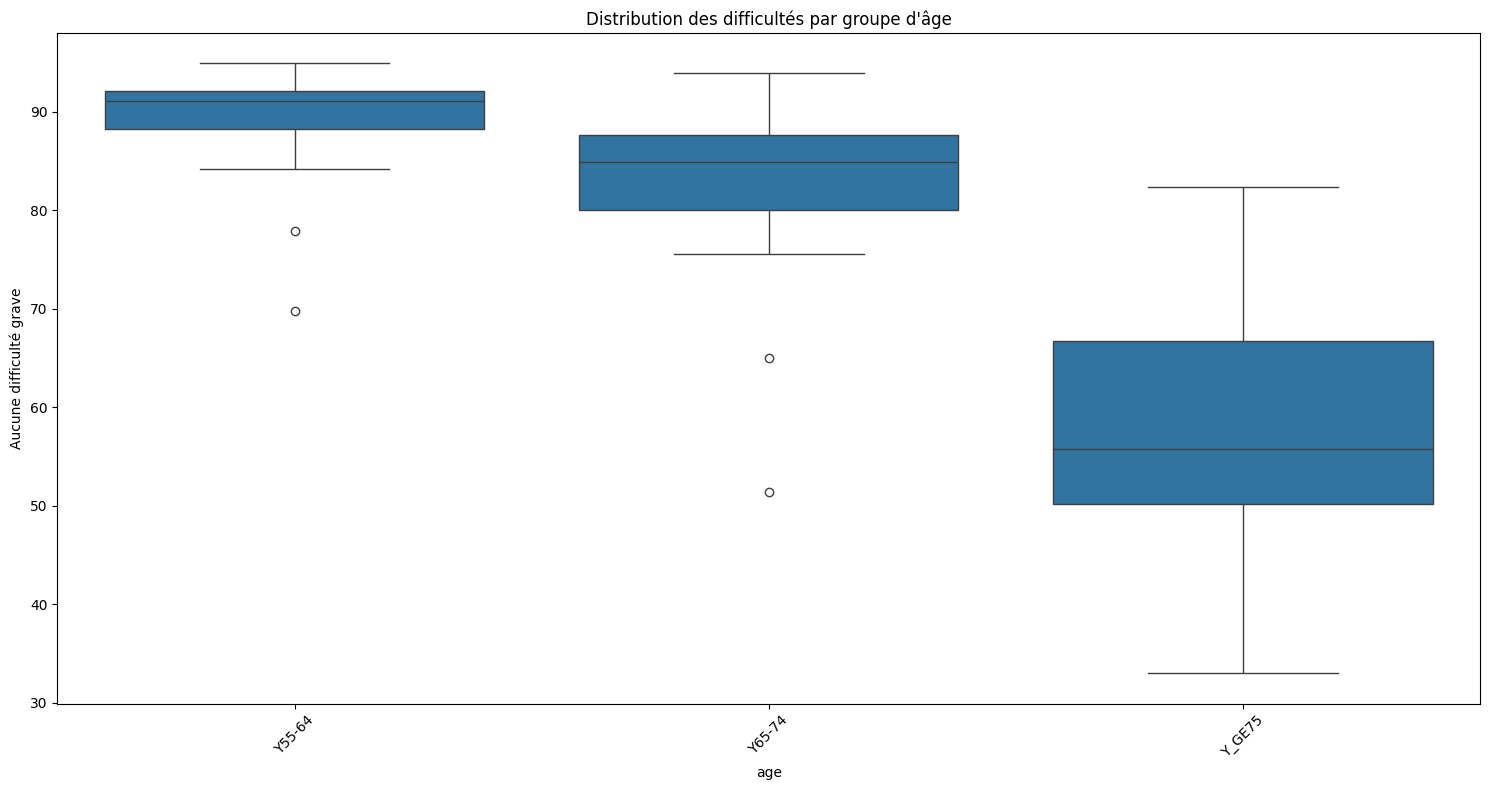


Statistiques descriptives par groupe d'âge:
        count       mean        std   min     25%    50%     75%   max
age                                                                   
Y55-64   29.0  89.182759   5.196432  69.8  88.200  91.10  92.100  94.9
Y65-74   30.0  83.333333   8.654133  51.4  79.975  84.90  87.600  93.9
Y_GE75   30.0  57.833333  13.092044  33.0  50.225  55.75  66.725  82.3


In [ ]:
import scipy.stats as stats
import numpy as np

# 1. Préparation des données pour ANOVA
# Créons d'abord des groupes par âge pour l'analyse

# Filtrer pour ne garder que certaines tranches d'âge spécifiques
age_groups = ['Y55-64', 'Y65-74', 'Y_GE75']
df_anova = df_pivoted[df_pivoted['age'].isin(age_groups)]

# 2. ANOVA pour comparer les difficultés entre les groupes d'âge
# Pour chaque type de difficulté
for colonne in ['Aucune difficulté grave',
                'Difficulté grave uniquement pour effectuer des soins personnels - activités de la vie quotidienne (AVQ)',
                'Difficulté grave uniquement pour accomplir des activités domestiques - activités instrumentales de la vie quotidienne (AIVQ)',
                'Difficulté grave à la fois pour effectuer des soins personnels ainsi que d\'accomplir des activités domestiques - toutes les activités de la vie quotidienne (TAVQ)']:

    # Créer des groupes pour l'ANOVA
    groups = [group[colonne].dropna() for name, group in df_anova.groupby('age')]

    # Effectuer l'ANOVA
    f_statistic, p_value = stats.f_oneway(*groups)

    print(f"\nRésultats ANOVA pour {colonne}:")
    print(f"F-statistic: {f_statistic:.4f}")
    print(f"p-value: {p_value:.4f}")

    # Test post-hoc de Tukey si l'ANOVA est significative
    if p_value < 0.05:
        from statsmodels.stats.multicomp import pairwise_tukeyhsd
        tukey = pairwise_tukeyhsd(endog=df_anova[colonne],
                                 groups=df_anova['age'],
                                 alpha=0.05)
        print("\nRésultats du test de Tukey:")
        print(tukey)

# 3. Visualisation des résultats
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))
sns.boxplot(x='age', y='Aucune difficulté grave', data=df_anova)
plt.title('Distribution des difficultés par groupe d\'âge')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. Statistiques descriptives par groupe d'âge
print("\nStatistiques descriptives par groupe d'âge:")
print(df_anova.groupby('age')['Aucune difficulté grave'].describe())

Pour chaque groupe d'âge, on regarde le pourcentage de personnes qui n'ont "Aucune difficulté grave". Analysons groupe par groupe :


*   Pour les 55-64 ans : La moitié des pays (50% ou médiane) ont plus de 91.1% de personnes sans difficulté
*   Pour les 65-74 ans : La moitié des pays ont plus de 84.9% de personnes sans difficulté
* Pour les 75 ans et plus : La moitié des pays ont plus de 55.75% de personnes sans difficulté




